In [1]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\frank\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Validation Results Analysis

This notebook analyzes the validation results from different model runs to compare their performance.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import os

# Set style for better visualizations
sns.set_theme()
sns.set_palette('husl')

## Load and Process Validation Results

In [3]:
# Define paths to validation results
validation_files = {
    "LLaMA 3.2 (20250405)": "outputs/llama_3.2_11B_20250405_191725/val_results.csv",
    "LLaMA 3.2 Base": "outputs/llama_3.2/val_results.csv",
    "Qwen 2": "outputs/qwen_2/val_results_20250403_041212.csv",
}

# Dictionary to store results
results = {}

# Load and process each validation file
for model_name, file_path in validation_files.items():
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        results[model_name] = df
        print(f"Loaded {model_name} results: {len(df)} samples")
    else:
        print(f"Warning: {file_path} not found")

Loaded LLaMA 3.2 (20250405) results: 300 samples
Loaded LLaMA 3.2 Base results: 300 samples
Loaded Qwen 2 results: 300 samples


## Calculate Performance Metrics

In [4]:
# Calculate metrics for each model
metrics = {}
for model_name, df in results.items():
    # Convert target from tensor string to float
    y_true = df['target'].str.extract(r'tensor\(([\d.]+)').astype(float)
    # Extract prediction from response (Yes/No)
    y_pred = df['response'].str.contains('<answer>\s*Yes\s*</answer>', regex=True).astype(int)
    # For probability, we'll use a simple heuristic based on confidence in the response
    y_prob = df['response'].str.contains('immediate threat|potential risk|threat of collision', case=False).astype(float)
    
    metrics[model_name] = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_prob)
    }

# Convert to DataFrame for easier comparison
metrics_df = pd.DataFrame(metrics).T
metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC
LLaMA 3.2 (20250405),0.500000,0.5,1.000000,0.666667,0.5
LLaMA 3.2 Base,0.546667,1.0,0.093333,0.170732,0.5
Qwen 2,0.500000,0.5,1.000000,0.666667,0.5


## Visualize Performance Metrics

<Figure size 1200x600 with 0 Axes>

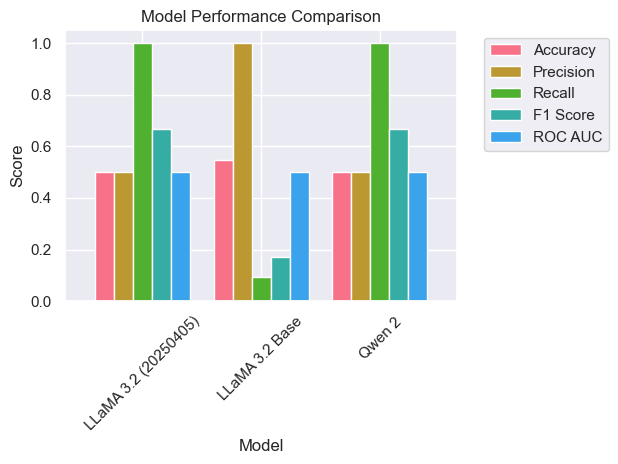

In [5]:
# Plot metrics comparison
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', width=0.8)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Confusion Matrices

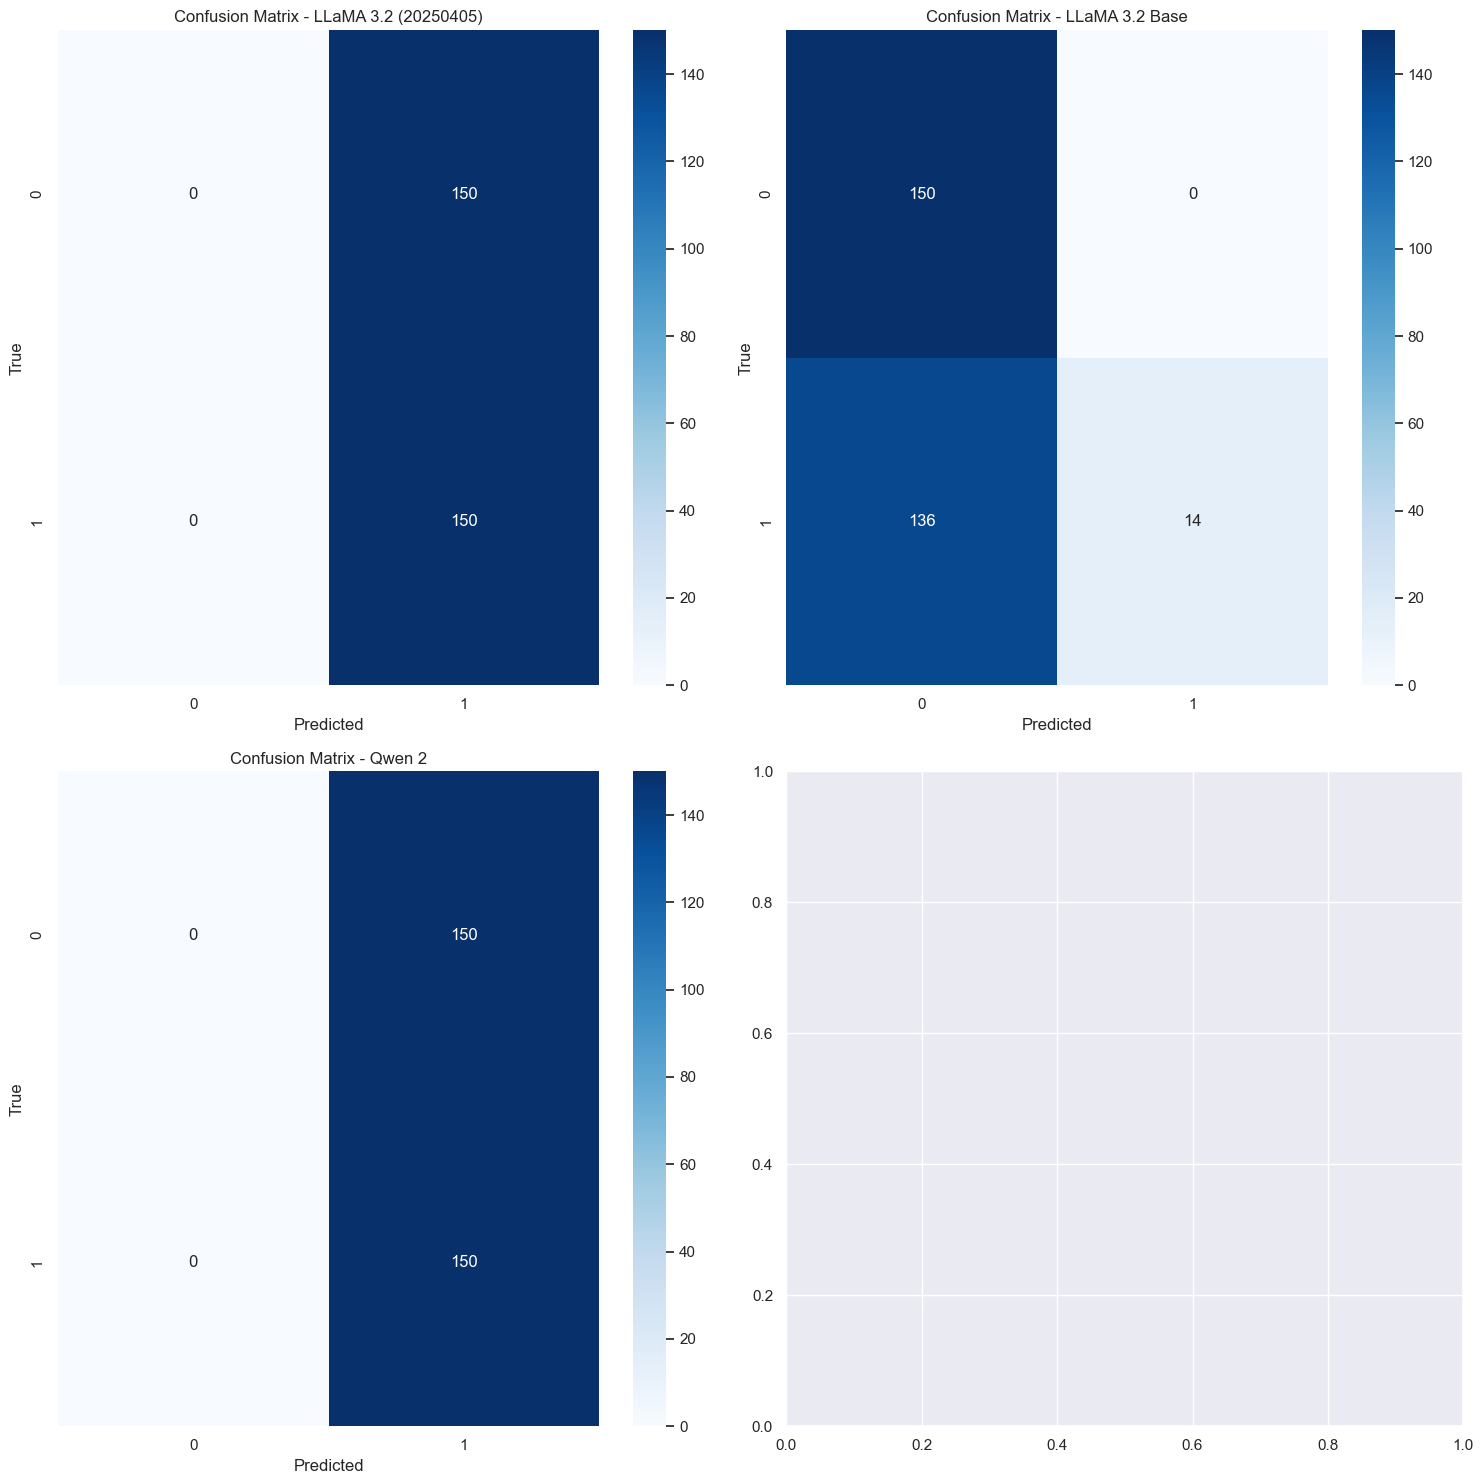

In [6]:
# Plot confusion matrices for each model
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for idx, (model_name, df) in enumerate(results.items()):
    # Convert target from tensor string to float
    y_true = df['target'].str.extract(r'tensor\(([\d.]+)').astype(float)
    # Extract prediction from response (Yes/No)
    y_pred = df['response'].str.contains('<answer>\s*Yes\s*</answer>', regex=True).astype(int)
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix - {model_name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')
    
plt.tight_layout()
plt.show()

## ROC Curves

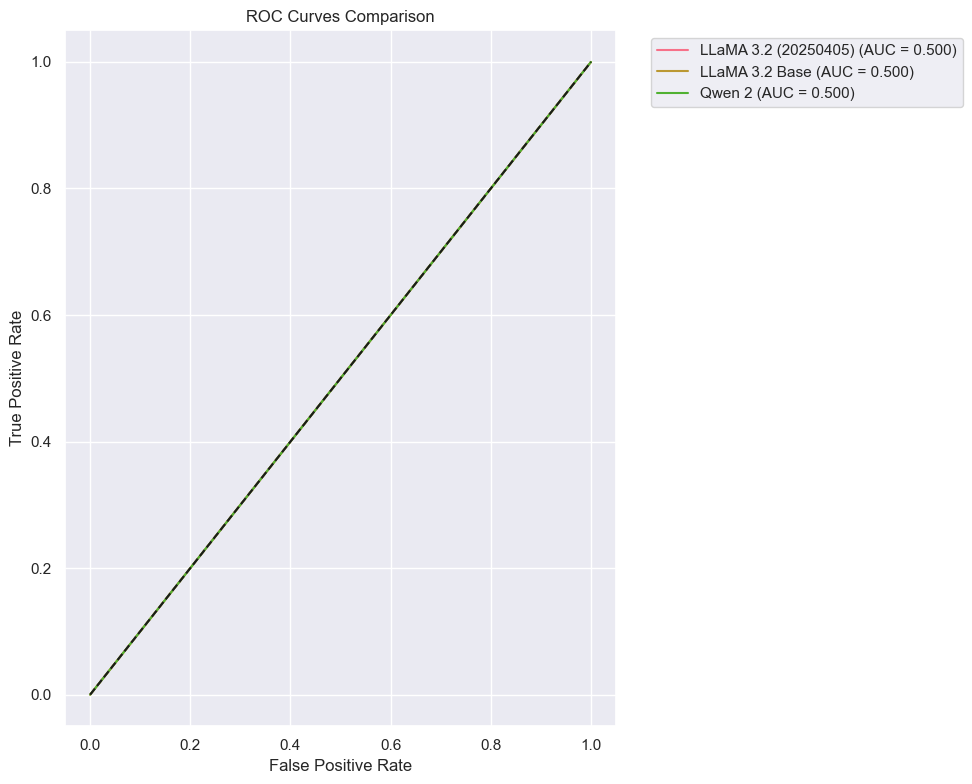

In [7]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

for model_name, df in results.items():
    # Convert target from tensor string to float
    y_true = df['target'].str.extract(r'tensor\(([\d.]+)').astype(float)
    # Extract probability based on confidence in the response
    y_prob = df['response'].str.contains('immediate threat|potential risk|threat of collision', case=False).astype(float)
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_true, y_prob):.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()